# 第三次讀書會報告-LDA

組別:第9組

Date:2024/05/07

# 1.載入環境及安裝套件

In [1]:
import time 
from functools import reduce
from collections import Counter
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jieba
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.matutils import corpus2csc, corpus2dense, Sparse2Corpus

import pyLDAvis
import pyLDAvis.gensim_models
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
# 設定圖的字體大小
plt.rcParams['font.size'] = 14

# 設定中文字體 (無法顯示的話可以試試‘Microsoft JhengHei’字體)
# 也可參考：https://pyecontech.com/2020/03/27/python_matplotlib_chinese/
plt.rcParams['font.sans-serif'] = ['Arial Unicode Ms']
plt.rcParams['axes.unicode_minus']=False

#圖型相關設定
%matplotlib inline

plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['figure.dpi'] = 120

# 2.資料前處理

## 2.1資料蒐集
本小組自Tarflow下載Dacrd上4個個版的文章資料集，並執行程式合成一個資料集，共3,598筆資料。

其內容包含system_id、ataSource、artUrl、artDate、artTitle、artContent、boardID(文章所屬個版)、
commentCount(評論次數)、department、gender、school等欄位。

Data includes:
*   Dcard文章 from 2024/03/01 - 2024/03/25
*   專版包含以下4板：
*   穿搭版
*   星座版
*   理財版
*   研究所版

資料來源:https://tarflow.mis.nsysu.edu.tw/login?next=%2Fmain%2F662d88ed73

## 2.2資料匯入與清理

In [3]:
##讀取資料集
dcard_df = pd.read_csv("./2024_study_group9_3/raw_data/dcard_dataset/dcard_set.csv")
dcard_df

,system_id,dataSource,artUrl,artDate,artTitle,artContent,boardID,commentCount,department,gender,school
0,1,Dcard,https://www.dcard.tw/f/dressup/p/255078442,2024-03-25 16:18:42,#分享 150の近期日常裙裝穿搭🌸🧸 #穿出我的日系風格,https://megapx.dcard.tw/v1/images/e6ee0893-3a7...,dressup,40,ruuuuu___,F,まる🐻
1,2,Dcard,https://www.dcard.tw/f/dressup/p/255078768,2024-03-25 16:54:35,穿出我的日系風格,\麵包超人/\n因為本身長相無優勢\n所以決定用麵包超人的型態出場🤩✨\n窮超人本人真的好想...,dressup,21,clumnar,F,阿胖麵人
2,3,Dcard,https://www.dcard.tw/f/dressup/p/255078701,2024-03-25 16:45:46,#詢問 科技業女生穿搭,原本在新創公司上班，平常上班穿搭沒在管\n穿短褲、露肚臍、戴帽子 都可以\n\n但下週轉職換...,dressup,352,NaN,F,國立政治大學
3,4,Dcard,https://www.dcard.tw/f/dressup/p/255079599,2024-03-25 21:31:16,找不到李多慧的瑜伽褲品牌,NaN,dressup,3,softcindy,F,豆腐心老貓奴
4,5,Dcard,https://www.dcard.tw/f/dressup/p/255065394,2024-03-24 10:59:45,#分享 172的黑色衣櫃🐈‍⬛✨,https://megapx.dcard.tw/v1/images/61f1cb51-fb7...,dressup,24,bea.16,F,172
...,...,...,...,...,...,...,...,...,...,...,...
3593,948,Dcard,https://www.dcard.tw/f/graduate_school/p/25486...,2024-03-03 13:17:05,收王達昌經濟學研究所講義,想要自讀 有講義、小考考卷的話最好\n非常感謝,graduate_school,5,NaN,M,國立臺北大學
3594,949,Dcard,https://www.dcard.tw/f/graduate_school/p/25486...,2024-03-03 22:40:19,研究所上課方式,請教一下各位\n大家唸研究所的上課方式？\n我是第一堂課教授會講一下課程大綱、報告內容、分組...,graduate_school,11,mentalillness,F,吓聊
3595,950,Dcard,https://www.dcard.tw/f/graduate_school/p/25486...,2024-03-03 14:23:21,中興應用經濟所在職專班面試,各位好！\n本人有幸通過中興應經在職專班的第一階段審查\n想請問各位面試方面除了自我介紹外教...,graduate_school,0,volleyball123,M,白底虎斑
3596,951,Dcard,https://www.dcard.tw/f/graduate_school/p/25484...,2024-03-02 06:05:29,高雄大學 亞太工商學系 教授請益,今年考試本人正取，想請益有關高大亞太系的教授\n\n目前有興趣的教授有：\n1.許博翔 教授...,graduate_school,1,NaN,M,國立聯合大學


In [4]:
#資料集中可能有等於0或是NaN的值，故用索引選擇不等於0且不是NaN的值，接著使用dropna()方法刪除NaN的行
dcard_df = dcard_df[(dcard_df !=0) & (dcard_df.notna())].dropna()
dcard_df

,system_id,dataSource,artUrl,artDate,artTitle,artContent,boardID,commentCount,department,gender,school
0,1,Dcard,https://www.dcard.tw/f/dressup/p/255078442,2024-03-25 16:18:42,#分享 150の近期日常裙裝穿搭🌸🧸 #穿出我的日系風格,https://megapx.dcard.tw/v1/images/e6ee0893-3a7...,dressup,40.0,ruuuuu___,F,まる🐻
1,2,Dcard,https://www.dcard.tw/f/dressup/p/255078768,2024-03-25 16:54:35,穿出我的日系風格,\麵包超人/\n因為本身長相無優勢\n所以決定用麵包超人的型態出場🤩✨\n窮超人本人真的好想...,dressup,21.0,clumnar,F,阿胖麵人
4,5,Dcard,https://www.dcard.tw/f/dressup/p/255065394,2024-03-24 10:59:45,#分享 172的黑色衣櫃🐈‍⬛✨,https://megapx.dcard.tw/v1/images/61f1cb51-fb7...,dressup,24.0,bea.16,F,172
6,7,Dcard,https://www.dcard.tw/f/dressup/p/255047494,2024-03-22 10:00:10,#分享 小隻女孩𝟭𝟱𝟬𝗰𝗺 🍯近期最愛的𝟯件日牌洋裝分享(´ᵒ̴̶̷̤∀ᵒ̴̶̷̤)💛,https://megapx.dcard.tw/v1/images/dbbc7b1a-dec...,dressup,75.0,ningggg131,F,ニン·Ning
7,8,Dcard,https://www.dcard.tw/f/dressup/p/255065466,2024-03-24 11:08:57,#分享 161挑戰可甜可鹽4種穿搭🎀,哈囉大家好我是草莓奶昔🍓\n平常都在美妝版出沒的我\n今天要來分享4套可甜可鹹的穿搭🙈\n有...,dressup,5.0,susu.310,F,草莓奶昔🍓
...,...,...,...,...,...,...,...,...,...,...,...
3588,943,Dcard,https://www.dcard.tw/f/graduate_school/p/25483...,2024-03-01 12:00:12,非本科系準備機械碩士在職班,大家好\n\n請問非本科系想讀機械碩士在職班\n\n工作是機構工程師有機會進機械所嗎 ?\n...,graduate_school,5.0,工業設計學系,M,國立臺北科技大學
3590,945,Dcard,https://www.dcard.tw/f/graduate_school/p/25485...,2024-03-03 11:16:03,是否繼續讀社工研究所,不知道發這版對不對\n但是還是想問問就讀過研究所的各位\n是否該繼續就讀社工的研究所？\n\...,graduate_school,6.0,c92929,F,Lulu
3591,946,Dcard,https://www.dcard.tw/f/graduate_school/p/25483...,2024-03-01 11:01:16,大碩vs高點 管理學,目前在考慮報企研所 試聽過兩家\n管理學大碩趙老師的那堂試聽完全沒板書（線上試聽只有那堂）所...,graduate_school,18.0,laurenceee,F,🫶🏻
3592,947,Dcard,https://www.dcard.tw/f/graduate_school/p/25485...,2024-03-03 13:10:51,［分享］113台大應數所推甄,推甄分三步驟，就依順序來說：\n\n一、上傳資料：\n簡單來說就是把一些大學的豐功偉業上傳，...,graduate_school,2.0,cb26_2219,M,匿名


In [5]:
# 移除網址格式
# 只留下中文字
dcard_df["artContent"] = dcard_df["artContent"].str.replace("(http|https)://.*", "", regex=True)
dcard_df["artTitle"] = dcard_df["artTitle"].str.replace("(http|https)://.*", "", regex=True)
dcard_df["artContent"] = dcard_df["artContent"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
dcard_df["artTitle"] = dcard_df["artTitle"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
dcard_df['content'] = dcard_df['artContent']
dcard_df['artCatagory'] = dcard_df['boardID']

dcard_df = dcard_df.loc[:,["content", "artUrl", "artCatagory", 'artDate']] #留下文章內容、文章連結與文章種類
dcard_df.head(3)

,content,artUrl,artCatagory,artDate
0,大家好我是身高體重很喜歡裙裝所以衣櫃裡幾乎找不到褲子照片都是出去玩時拍的不過是出遊順便拍的不...,https://www.dcard.tw/f/dressup/p/255078442,dressup,2024-03-25 16:18:42
1,麵包超人因為本身長相無優勢所以決定用麵包超人的型態出場窮超人本人真的好想獲得購物金第一套是休...,https://www.dcard.tw/f/dressup/p/255078768,dressup,2024-03-25 16:54:35
4,哈囉大家好久不見竟然隔了兩年風格跟以前好像轉變蠻大的現在都穿深色系為主簡單又搭啊身高體重還是...,https://www.dcard.tw/f/dressup/p/255065394,dressup,2024-03-24 10:59:45


In [6]:
#將artCatagory從英文轉中文
dcard_df["artCatagory"] = dcard_df["artCatagory"].replace('dressup','穿搭')
dcard_df["artCatagory"] = dcard_df["artCatagory"].replace('horoscopes','星座')
dcard_df["artCatagory"] = dcard_df["artCatagory"].replace('money','理財')
dcard_df["artCatagory"] = dcard_df["artCatagory"].replace('graduate_school','研究所')

In [7]:
dcard_df["artCatagory"]

0        穿搭
1        穿搭
4        穿搭
6        穿搭
7        穿搭
       ... 
3588    研究所
3590    研究所
3591    研究所
3592    研究所
3594    研究所
Name: artCatagory, Length: 1249, dtype: object

## 2.3資料停用詞與斷詞使用

In [8]:
# 設定繁體中文詞庫
jieba.set_dictionary("./2024_study_group9_3/dict/dict.txt.big")

# 新增stopwords
# jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open("./2024_study_group9_3/dict/stop_words.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list


# dcard_df = pd.DataFrame(dcard_df['content'].astype(str))
# dcard_df = dcard_df.dropna(axis=1)
dcard_df["words"] = dcard_df['content'].apply(getToken)
dcard_df.head()

Building prefix dict from /Users/billyke/2024_study_group9_3/dict/dict.txt.big ...
2024-05-05 23:10:23,325 : DEBUG : Building prefix dict from /Users/billyke/2024_study_group9_3/dict/dict.txt.big ...
Dumping model to file cache /var/folders/ng/25l3_vws2cl593j20n75bcy00000gn/T/jieba.ub817e87c4f44254fcc0f9ec94260f77a.cache
2024-05-05 23:10:23,889 : DEBUG : Dumping model to file cache /var/folders/ng/25l3_vws2cl593j20n75bcy00000gn/T/jieba.ub817e87c4f44254fcc0f9ec94260f77a.cache
Loading model cost 0.619 seconds.
2024-05-05 23:10:23,945 : DEBUG : Loading model cost 0.619 seconds.
Prefix dict has been built successfully.
2024-05-05 23:10:23,946 : DEBUG : Prefix dict has been built successfully.


,content,artUrl,artCatagory,artDate,words
0,大家好我是身高體重很喜歡裙裝所以衣櫃裡幾乎找不到褲子照片都是出去玩時拍的不過是出遊順便拍的不...,https://www.dcard.tw/f/dressup/p/255078442,穿搭,2024-03-25 16:18:42,"[身高體重, 喜歡, 裙裝, 衣櫃, 不到, 褲子, 照片, 出去玩, 出遊, 順便, 專業..."
1,麵包超人因為本身長相無優勢所以決定用麵包超人的型態出場窮超人本人真的好想獲得購物金第一套是休...,https://www.dcard.tw/f/dressup/p/255078768,穿搭,2024-03-25 16:54:35,"[超人, 長相, 優勢, 決定, 超人, 型態, 出場, 超人, 真的, 獲得, 購物, 第..."
4,哈囉大家好久不見竟然隔了兩年風格跟以前好像轉變蠻大的現在都穿深色系為主簡單又搭啊身高體重還是...,https://www.dcard.tw/f/dressup/p/255065394,穿搭,2024-03-24 10:59:45,"[哈囉, 好久不見, 兩年, 風格, 以前, 好像, 轉變, 蠻大, 現在, 深色, 系為,..."
6,嗨嗨我是寧這次想來和大家分享我最近新入手的日牌洋裝們果然小隻女孩買日牌就是不會錯長度都會很剛...,https://www.dcard.tw/f/dressup/p/255047494,穿搭,2024-03-22 10:00:10,"[是寧, 這次, 想來, 分享, 最近, 入手, 日牌, 洋裝, 女孩, 買日牌, 不會錯,..."
7,哈囉大家好我是草莓奶昔平常都在美妝版出沒的我今天要來分享套可甜可鹹的穿搭有興趣的就一起看下去...,https://www.dcard.tw/f/dressup/p/255065466,穿搭,2024-03-24 11:08:57,"[哈囉, 草莓, 奶昔, 平常, 美妝版, 出沒, 今天, 要來, 分享, 興趣, 一起, ..."


In [9]:
#列出此資料集包含Dcard哪幾個個版
dcard_df['artCatagory'].unique()

array(['穿搭', '星座', '理財', '研究所'], dtype=object)

顯示不同主題出現最常出現的詞

In [10]:
## 定義主題(穿搭)
dcard_df_dressup = dcard_df.loc[dcard_df['artCatagory'] == '穿搭',:]['words'].explode().value_counts().head(100)
dcard_df_dressup.index

Index(['喜歡', '分享', '搭配', '上衣', '外套', '真的', '這件', '比較', '覺得', '鞋子', '衣服', '洋裝',
       '背心', '感覺', '褲子', '裙子', '適合', '好看', '一件', '這次', '針織', '設計', '顏色', '可愛',
       '白色', '襯衫', '最近', '這套', '風格', '黑色', '一點', '包包', '材質', '整體', '有點', '長裙',
       '單品', '希望', '看到', '知道', '超級', '以上', '蝦皮', '一套', '今天', '毛衣', '淘寶', '天氣',
       '謝謝', '朋友', '簡單', '裡面', '歡迎', '一下', '帽子', '日本', '日常', '版型', '選擇', '最後',
       '一些', '第一套', '牛仔', '韓國', '日系', '灰色', '一起', '特別', '留言', '牛仔褲', '應該',
       '直接', '推薦', '購入', '發現', '出門', '蕾絲', '照片', '保暖', '透膚', '春天', '拍照', '罩衫',
       '粉色', '下次', '高領', '造型', '嘗試', '項鍊', '一直', '之前', '第二套', '藍色', '近期',
       '第一次', '舒服', '一定', '完全', '想要', '短裙'],
      dtype='object', name='words')

In [11]:
## 列出主題字詞(星座)
dcard_df_horoscopes = dcard_df.loc[dcard_df['artCatagory'] == '星座',:]['words'].explode().value_counts().head(200)
pprint(" ".join(dcard_df_horoscopes.index))

('朋友 喜歡 覺得 感情 知道 星座 真的 一起 工作 對方 主動 問題 事情 最近 比較 現在 處女 感覺 認識 方面 聊天 需要 訊息 時間 女生 '
 '有點 水瓶 一下 一直 想要 之前 遇到 之後 容易 相處 金牛 處女座 曖昧 一點 一些 已經 雙魚 直接 目前 應該 想法 交往 關係 看到 好好 '
 '兩個 不想 突然 一次 最後 獅子 告白 見面 真愛 生活 告訴 金牛座 分手 好感 分享 一定 關心 發現 好像 請問 天蠍 天蠍座 機會 吵架 對象 '
 '每天 來說 希望 一週 雙魚座 射手座 話題 特別 今天 牡羊 願意 方式 溝通 開心 適合 射手 有沒有 感受 無法 雙子 不好 電話 情緒 我會 '
 '勇敢 天秤 看看 巨蟹 有時候 給我 辦法 總是 地方 意思 幾天 變得 面對 生氣 水瓶座 變成 繼續 事業 完全 了解 魔羯 注意 男友 說話 這是 '
 '分開 獅子座 發生 聯絡 超級 譬如說 拒絕 雙子座 不用 心裡 私訊 同事 東西 狀況 晚上 沒事 運勢 個性 後面 男生 部分 太陽 通常 伴侶 '
 '重要 相信 改變 人生 愛情 他會 這段 回答 代表 吃飯 每次 追求 出門 接觸 平常 小心 不到 我問 秘密 幫忙 同學 思考 每個 第一次 答案 '
 '壓力 互動 一種 能力 在意 以下 謝謝 桃花 行為 吸引 原因 狀態 難過 過程 回來 可愛 另一半 還會 前任 原本 很大 牡羊女 歡迎 觀察 文章 '
 '詢問 過去')


In [12]:
## 列出主題字詞(理財)
dcard_df_money = dcard_df.loc[dcard_df['artCatagory'] == '理財',:]['words'].explode().value_counts().head(200)
pprint(" ".join(dcard_df_money.index))

('投資 目前 利率 股票 貸款 比較 現在 比特 銀行 資金 需要 請問 公司 利息 報酬 價格 時間 定期 知道 現金 資產 分享 信貸 市場 申請 '
 '問題 股息 理財 定額 金額 最近 建議 每個 已經 工作 覺得 使用 謝謝 直接 應該 持續 以上 一下 希望 美債 一些 之後 配息 帳戶 信用卡 '
 '真的 風險 投入 一年 策略 看到 選擇 國泰 交易 條件 貨幣 申購 推薦 長期 歡迎 淨資產 手續費 今天 詢問 一次 買入 一個月 方式 每月 '
 '主力 中信 情況 買進 美股 最後 是否 平均 考慮 永豐 繼續 一點 加密 市值 質押 台灣 交易所 指數 許多 收入 負債 獲利 台股 儲蓄 操作 '
 '本金 超過 認為 支出 進場 朋友 未來 開戶 以下 左右 提供 分析 今年 不用 去年 部分 報酬率 討論 股市 主要 台幣 想要 文章 融資 發現 '
 '一直 帳號 能夠 降息 有點 變成 有人 穩定 成長 之前 股利 透過 趨勢 機會 辦法 每年 一筆 內容 大盤 增加 有沒有 一起 重要 兩個 維持 '
 '持有 目標 行情 勝率 社群 簡單 累積 定存 基金 美國 無法 請教 來說 歷史 追蹤 證券 不錯 只能 感謝 成本 賣出 知識 薪水 價值 鐵蛋 '
 '賣掉 萬左右 下來 幾個 出現 這是 這裡 了解 這次 高點 配置 房子 當時 注意 喜歡 一定 調整 標的 量化 突破 額度 固定 小弟 假設 股東 '
 '關係')


In [13]:
#列出主題字詞(研究所)
dcard_df_graduate_school = dcard_df.loc[dcard_df['artCatagory'] == '研究所',:]['words'].explode().value_counts().head(200)
pprint(" ".join(dcard_df_graduate_school.index))

('教授 老師 面試 請問 比較 知道 目前 備取 學長 準備 研究 問題 一下 謝謝 考試 題目 今年 真的 時間 畢業 實驗室 相關 研究所 希望 覺得 '
 '英文 小弟 分享 大學 學校 詢問 建議 感謝 有沒有 最後 成績 需要 資訊 正取 機會 台大 想問 看到 一些 回答 有點 臺大 臺灣 推薦 資料 '
 '放榜 領域 想要 計畫 應該 未來 感覺 方向 選擇 中山 現在 中央 部分 內容 興趣 工作 一定 朋友 幫助 好像 專題 中興 已經 課程 有幸 '
 '學生 讀書 文章 閱讀 之後 交大 重要 去年 背景 過程 分數 經驗 補習班 政治 概念 確定 發現 報名 有人 完全 實習 同學 期間 科技 中國 '
 '提供 能力 面談 進行 是否 幫忙 問卷 方式 之前 心得 統計 錄取 兩年 評價 專業 考古題 討論 使用 碩士 實驗 分鐘 了解 情況 最近 電機 '
 '名額 清楚 師大 上榜 兩間 化工 以上 只能 緊張 看看 一起 東西 中正 備考 科目 資管 前面 筆記 利用 寄信 直接 一點 主要 影響 每個 '
 '基因 喜歡 小時 努力 金融 考上 順利 每天 機械 簡單 成大 考生 電子 印象 找到 動機 問問 答案 政治學 當初 制度 自我介紹 今天 葡萄糖 '
 '特別 後面 一次 兩個 世界史 記得 數學 作者 申請 台北 考慮 重考 不太 請教 超級 想法 就讀 意見 分析 雲端 網路上 前輩 一直 放棄 本書 '
 '歐洲')


In [14]:
#自訂主題詞彙(參照上面4個主題的字詞)
custom_topic_word = {
    "穿搭": [
        "搭配",
        "上衣",
        "外套",
        "一件",
        "比較",
        "衣服",
        "洋裝",
        "鞋子",
        "背心",
        "可愛",
        "褲子",
        "裙子",
        "適合",
        "針織",
        "設計",
        "顏色",
        "襯衫",
        "風格",
        "材質",
        "包包",
        "整體",
        "蝦皮",
        "淘寶",
        "毛衣",
        "帽子",
        "版型",
        "勇士",
        "牛仔",
        "日常",
        "牛仔褲",
        "高領", 
        "造型",
        "保暖",
        "項鍊",
        "短裙",
        "罩衫",
        "透膚",
        "蕾絲",
    ],
    "星座": [
        "感情",
        "對方",
        "認識",
        "處女",
        "聊天",
        "訊息",
        "水瓶",
        "相處",
        "曖昧",
        "金牛",
        "交往",
        "關係",
        "牡羊",
        "雙魚",
        "獅子",
        "告白",
        "勇敢",
        "天秤",
        "巨蟹",
        "雙子",
        "運勢",
        "個性",
        "太陽",
        "桃花",
    ],
    "理財": [
        "投資",
        "股票",
        "利率",
        "貸款",
        "銀行",
        "比特",
        "資金",
        "利息",
        "報酬",
        "信貸",
        "資產",
        "風險",
        "申購",
        "淨資產",
        "手續費",
        "信用卡",
        "配息",
        "儲蓄",
        "台股",
        "證券",
        "定存",
        "基金",
        "大盤",
        "台幣",
        "融資",
        "薪水",
        "國泰",
        "中信",
        "永豐",
    ],
    "研究所": [
        "教授",
        "面試",
        "實驗室",
        "碩士",
        "實習",
        "面談",
        "問卷",
        "考古題",
        "研究計畫",
        "中山",
        "放榜",
        "畢業",
        "錄取",
    ],
}

In [15]:
#建立vocabulary
vocabularies = np.unique(reduce(lambda x, y: x + y, custom_topic_word.values()))

In [16]:
vocabularies

array(['一件', '上衣', '中信', '中山', '交往', '保暖', '信用卡', '信貸', '個性', '儲蓄', '利息',
       '利率', '勇士', '勇敢', '包包', '可愛', '台幣', '台股', '告白', '問卷', '國泰', '基金',
       '報酬', '外套', '大盤', '天秤', '太陽', '定存', '實習', '實驗室', '對方', '巨蟹', '帽子',
       '感情', '手續費', '投資', '搭配', '放榜', '教授', '整體', '日常', '曖昧', '材質', '桃花',
       '比特', '比較', '毛衣', '水瓶', '永豐', '洋裝', '淘寶', '淨資產', '版型', '牛仔', '牛仔褲',
       '牡羊', '獅子', '申購', '畢業', '相處', '短裙', '研究計畫', '碩士', '罩衫', '考古題',
       '聊天', '股票', '背心', '蕾絲', '薪水', '處女', '蝦皮', '融資', '衣服', '裙子', '褲子',
       '襯衫', '訊息', '設計', '認識', '證券', '貸款', '資產', '資金', '透膚', '造型', '運勢',
       '適合', '配息', '金牛', '針織', '銀行', '錄取', '關係', '雙子', '雙魚', '面試', '面談',
       '鞋子', '項鍊', '顏色', '風格', '風險', '高領'], dtype='<U4')

In [17]:
#利用 CountVectorizer 的 vocabulary 參數來篩選、製作 DTM
dcard_df_corpus = dcard_df['words'].map(" ".join)
vectorizer = CountVectorizer(vocabulary=vocabularies)
dcard_df_matrix = vectorizer.fit_transform(dcard_df_corpus)

dcard_df_matrix = dcard_df_matrix.toarray()
feature_names = vectorizer.get_feature_names_out()

In [18]:
dcard_df_matrix.shape

(1249, 104)

In [19]:
df_count = pd.DataFrame({})

for k, v in custom_topic_word.items():
    idx = np.isin(
        feature_names,
        v
    )
    df_count[f'topic_{k}'] = dcard_df_matrix[:, idx].sum(axis=1)
    
df_count

,topic_穿搭,topic_星座,topic_理財,topic_研究所
0,40,0,0,0
1,13,0,0,0
2,35,0,0,0
3,22,1,0,0
4,8,0,0,0
...,...,...,...,...
1244,1,0,0,1
1245,0,0,0,2
1246,1,0,0,0
1247,1,2,0,22


以上結果是因為資料集種類排序依序從穿搭、星座、理財、研究所

In [20]:
#列出θ值
thetas = df_count.div(
    df_count.sum(axis=1),
    axis=0
)
thetas.head()

,topic_穿搭,topic_星座,topic_理財,topic_研究所
0,1.000000,0.000000,0.0,0.0
1,1.000000,0.000000,0.0,0.0
2,1.000000,0.000000,0.0,0.0
3,0.956522,0.043478,0.0,0.0
4,1.000000,0.000000,0.0,0.0


## 2.3處理資料集文章

In [21]:
#將dataframe轉成list
docs = dcard_df['words'].to_list()
docs[0]

['身高體重',
 '喜歡',
 '裙裝',
 '衣櫃',
 '不到',
 '褲子',
 '照片',
 '出去玩',
 '出遊',
 '順便',
 '專業',
 '分享',
 '細節',
 '照片',
 '希望',
 '別介意',
 '喜歡',
 '裙裝',
 '就讓',
 '一起',
 '下去',
 '栗子',
 '布朗',
 '朋友',
 '可麗露',
 '專賣店',
 '咖啡廳',
 '可可',
 '起毛',
 '針織',
 '外套',
 '袖口',
 '圓圓',
 '蓬蓬',
 '設計',
 '真的',
 '可愛',
 '貝雷帽',
 '挑選',
 '巧克力',
 '咖啡廳',
 '深色',
 '想要',
 '巧克力',
 '保有',
 '乾淨',
 '感覺',
 '裙子',
 '搭配',
 '白色',
 '起毛',
 '針織',
 '外套',
 '奶油',
 '巧克力',
 '復古',
 '地方',
 '大地',
 '色系',
 '幾個',
 '禮拜',
 '天氣',
 '忽冷忽熱',
 '外套',
 '透透',
 '出場',
 '好時機',
 '洋裝',
 '格子狀',
 '真的',
 '超像',
 '一大塊',
 '巧克力',
 '吊帶',
 '洋裝',
 '想要',
 '可愛',
 '一點',
 '兩隻',
 '一些',
 '可愛',
 '髮飾',
 '點綴',
 '真心',
 '推薦',
 '頭髮',
 '一些',
 '哩哩',
 '可愛',
 '吊帶',
 '洋裝',
 '針織',
 '罩衫',
 '逛街',
 '蕾絲',
 '逛街',
 '香草',
 '冰淇淋',
 '尼們',
 '看錯',
 '這套',
 '派出',
 '外套',
 '透透',
 '這天',
 '行程',
 '看花',
 '希望',
 '溫柔',
 '挑選',
 '全身',
 '淡色',
 '搭配',
 '比較',
 '已經',
 '很花',
 '背景',
 '凸顯',
 '飾品',
 '配件',
 '選用',
 '珍珠',
 '整體',
 '主題性',
 '吊帶',
 '洋裝',
 '針織',
 '罩衫',
 '逛街',
 '透膚',
 '焦糖',
 '脆餅',
 '這天',
 '意外',
 '壽司店',
 '配色',
 '喜歡',
 '這件',
 '綁帶',
 '罩衫',

In [22]:
dictionary = Dictionary(docs)
# Filter out words that occur less than 5 documents, or more than 99% of the documents.
#篩選條件為字詞出現在少於五篇文章中或在99的文章中都會出現的字詞皆剔除
dictionary.filter_extremes(no_below=5, no_above=0.99)
print(dictionary)

2024-05-05 23:11:08,776 : INFO : adding document #0 to Dictionary<0 unique tokens: []>
2024-05-05 23:11:08,855 : INFO : built Dictionary<19335 unique tokens: ['一些', '一大塊', '一起', '一點', '下去']...> from 1249 documents (total 101192 corpus positions)
2024-05-05 23:11:08,856 : INFO : Dictionary lifecycle event {'msg': "built Dictionary<19335 unique tokens: ['一些', '一大塊', '一起', '一點', '下去']...> from 1249 documents (total 101192 corpus positions)", 'datetime': '2024-05-05T23:11:08.856097', 'gensim': '4.3.2', 'python': '3.9.15 | packaged by conda-forge | (main, Nov 22 2022, 08:52:10) \n[Clang 14.0.6 ]', 'platform': 'macOS-14.4.1-arm64-arm-64bit', 'event': 'created'}
2024-05-05 23:11:08,863 : INFO : discarding 16550 tokens: [('一大塊', 1), ('主題性', 1), ('保有', 4), ('兩隻', 4), ('冰淇淋', 4), ('別介意', 1), ('可可', 3), ('可麗露', 1), ('合內', 1), ('哩哩', 3)]...
2024-05-05 23:11:08,863 : INFO : keeping 2785 tokens which were in no less than 5 and no more than 1236 (=99.0%) documents
2024-05-05 23:11:08,867 : INFO : res

Dictionary<2785 unique tokens: ['一些', '一起', '一點', '下去', '不到']...>


In [23]:
for idx, (k, v) in enumerate(dictionary.token2id.items()):
    print(f"{k}: {v}")
    if idx > 10:
        break

一些: 0
一起: 1
一點: 2
下去: 3
不到: 4
乾淨: 5
側邊: 6
全身: 7
凸顯: 8
出去玩: 9
出場: 10
出遊: 11


In [24]:
#pprint(" ".join(dcard_df['words'].iloc[600]))

('辦理 途中 營業員 轉帳 帳戶 疑慮 打給 警察 帳戶 查詢 沒多久 三個 大漢 圍著 我問 許多 問題 我給 帳戶 給他 查詢 查完 之後 帳戶 檢舉 '
 '委託 想問 給錯 帳戶 應該 給圖 營業員 小心')


In [96]:
#dictionary.doc2bow(dcard_df['words'].iloc[600])[:10]

[(217, 1),
 (412, 1),
 (719, 1),
 (910, 1),
 (943, 1),
 (958, 1),
 (1184, 1),
 (1409, 1),
 (1664, 5),
 (1906, 1)]

In [24]:
# Bag-of-words representation of the documents.
# 用 gensim ldamodel input 需要將文章轉換成 bag of words 
corpus = [dictionary.doc2bow(doc) for doc in docs]
#確認corpus型態
type(corpus)

list

# 3.訓練 topic model(LDA)

## 3.1參數說明：

corpus = 文檔語料庫

id2word = 詞彙字典

num_topics = 生成幾個主題數

random_state = 固定亂數值，每次的模型結果會一樣

iteration = 每個文章訓練的次數，可以設定高一點讓模型收斂

passes(epoch) = 整個 corpus 訓練模型的次數

alpha = 文章主題分佈

eta = 主題字分佈

模型參數沒有一個絕對的答案，同學們應該使用相同的資料，嘗試做參數上的調整，進而比較出較佳的模型結果。

In [25]:
#建立模型
ldamodel = LdaModel(
    corpus=corpus, 
    id2word=dictionary, # 字典
    num_topics=10, # 生成幾個主題數
    #num_topics=8,
    random_state=2024, # 亂數
)

2024-05-05 23:11:27,269 : INFO : using symmetric alpha at 0.1
2024-05-05 23:11:27,273 : INFO : using symmetric eta at 0.1
2024-05-05 23:11:27,275 : INFO : using serial LDA version on this node
2024-05-05 23:11:27,282 : INFO : running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 1249 documents, updating model once every 1249 documents, evaluating perplexity every 1249 documents, iterating 50x with a convergence threshold of 0.001000
2024-05-05 23:11:27,283 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2024-05-05 23:11:27,605 : INFO : -9.010 per-word bound, 515.7 perplexity estimate based on a held-out corpus of 1249 documents with 72807 words
2024-05-05 23:11:27,605 : INFO : PROGRESS: pass 0, at document #1249/1249
2024-05-05 23:11:27,836 : INFO : topic #3 (0.100): 0.015*"喜歡" + 0.015*"分享" + 0.013*"上衣" + 0.010*"真的" + 0.009*"這件" + 0.009*"外套" + 0.009*"搭配" + 0.008*"比較

# 3.2 查看 LDA 主題代表字

當 LDA 模型訓練好之後，我們可以查看每個主題的單詞分佈。
num_words = 選擇要查看每個主題前幾個字。

In [26]:
ldamodel.print_topics()

2024-05-05 23:11:32,773 : INFO : topic #0 (0.100): 0.010*"分享" + 0.010*"喜歡" + 0.009*"真的" + 0.008*"目前" + 0.007*"教授" + 0.007*"比較" + 0.007*"覺得" + 0.006*"面試" + 0.006*"時間" + 0.005*"需要"
2024-05-05 23:11:32,777 : INFO : topic #1 (0.100): 0.008*"搭配" + 0.008*"分享" + 0.008*"目前" + 0.008*"上衣" + 0.008*"喜歡" + 0.007*"教授" + 0.007*"請問" + 0.007*"真的" + 0.006*"謝謝" + 0.006*"備取"
2024-05-05 23:11:32,778 : INFO : topic #2 (0.100): 0.010*"比較" + 0.009*"覺得" + 0.009*"目前" + 0.009*"真的" + 0.008*"知道" + 0.007*"喜歡" + 0.006*"問題" + 0.006*"外套" + 0.006*"搭配" + 0.005*"適合"
2024-05-05 23:11:32,780 : INFO : topic #3 (0.100): 0.015*"喜歡" + 0.015*"分享" + 0.013*"上衣" + 0.010*"真的" + 0.009*"這件" + 0.009*"外套" + 0.009*"搭配" + 0.008*"比較" + 0.008*"覺得" + 0.006*"褲子"
2024-05-05 23:11:32,781 : INFO : topic #4 (0.100): 0.013*"覺得" + 0.010*"投資" + 0.009*"喜歡" + 0.009*"朋友" + 0.008*"比較" + 0.007*"感覺" + 0.007*"知道" + 0.006*"最近" + 0.006*"分享" + 0.006*"真的"
2024-05-05 23:11:32,782 : INFO : topic #5 (0.100): 0.013*"搭配" + 0.010*"真的" + 0.010*"分享" + 0.009*"教授" + 0.

[(0,
  '0.010*"分享" + 0.010*"喜歡" + 0.009*"真的" + 0.008*"目前" + 0.007*"教授" + 0.007*"比較" + 0.007*"覺得" + 0.006*"面試" + 0.006*"時間" + 0.005*"需要"'),
 (1,
  '0.008*"搭配" + 0.008*"分享" + 0.008*"目前" + 0.008*"上衣" + 0.008*"喜歡" + 0.007*"教授" + 0.007*"請問" + 0.007*"真的" + 0.006*"謝謝" + 0.006*"備取"'),
 (2,
  '0.010*"比較" + 0.009*"覺得" + 0.009*"目前" + 0.009*"真的" + 0.008*"知道" + 0.007*"喜歡" + 0.006*"問題" + 0.006*"外套" + 0.006*"搭配" + 0.005*"適合"'),
 (3,
  '0.015*"喜歡" + 0.015*"分享" + 0.013*"上衣" + 0.010*"真的" + 0.009*"這件" + 0.009*"外套" + 0.009*"搭配" + 0.008*"比較" + 0.008*"覺得" + 0.006*"褲子"'),
 (4,
  '0.013*"覺得" + 0.010*"投資" + 0.009*"喜歡" + 0.009*"朋友" + 0.008*"比較" + 0.007*"感覺" + 0.007*"知道" + 0.006*"最近" + 0.006*"分享" + 0.006*"真的"'),
 (5,
  '0.013*"搭配" + 0.010*"真的" + 0.010*"分享" + 0.009*"教授" + 0.009*"比較" + 0.008*"覺得" + 0.006*"好看" + 0.006*"朋友" + 0.006*"知道" + 0.006*"外套"'),
 (6,
  '0.009*"喜歡" + 0.008*"真的" + 0.008*"比較" + 0.008*"分享" + 0.007*"襯衫" + 0.007*"搭配" + 0.007*"外套" + 0.007*"感覺" + 0.007*"上衣" + 0.007*"這件"'),
 (7,
  '0.014*"喜歡" + 0.013*

In [27]:
ldamodel.get_document_topics(corpus[0])

[(3, 0.56001246), (6, 0.12344865), (7, 0.31186953)]

## 3.3 查看 LDA 模型指標 

perplexity: 評估的指標之一，廣泛用於語言模型的評估，意思為複雜度，因此數字要越小越好。

Pointwise Mutual Information (PMI) :
自然語言處理中，想要探討兩個字之間是否存在某種關係。

例如：某些字會一起出現，可能帶有某些訊息，因此這個可以用 PMI 來計算，數字越大越好。

In [28]:
# perplexity(越小越好)
perplexity = ldamodel.log_perplexity(corpus)
perplexity

2024-05-05 23:11:38,516 : INFO : -7.652 per-word bound, 201.1 perplexity estimate based on a held-out corpus of 1249 documents with 72807 words


-7.651969102132698

In [29]:
np.exp2(-perplexity)

201.1278567118053

In [30]:
# npmi(越大越好)
NPMI_model_lda = CoherenceModel(model=ldamodel, texts=docs, coherence='c_npmi')
NPMI_lda = NPMI_model_lda.get_coherence()
print('這個主題的 PMI score: ', NPMI_lda)

2024-05-05 23:11:42,863 : INFO : using ParallelWordOccurrenceAccumulator<processes=9, batch_size=64> to estimate probabilities from sliding windows
2024-05-05 23:11:43,528 : INFO : 1 batches submitted to accumulate stats from 64 documents (6760 virtual)
2024-05-05 23:11:43,530 : INFO : 2 batches submitted to accumulate stats from 128 documents (13358 virtual)
2024-05-05 23:11:43,531 : INFO : 3 batches submitted to accumulate stats from 192 documents (19152 virtual)
2024-05-05 23:11:43,532 : INFO : 4 batches submitted to accumulate stats from 256 documents (24289 virtual)
2024-05-05 23:11:43,537 : INFO : 5 batches submitted to accumulate stats from 320 documents (29340 virtual)
2024-05-05 23:11:43,540 : INFO : 6 batches submitted to accumulate stats from 384 documents (36620 virtual)
2024-05-05 23:11:43,541 : INFO : 7 batches submitted to accumulate stats from 448 documents (43136 virtual)
2024-05-05 23:11:43,542 : INFO : 8 batches submitted to accumulate stats from 512 documents (48100

這個主題的 PMI score:  -0.02612448840167602


NPMI 的值域是[-1,1]，-1 代表兩個字沒一起出現過，0 代表兩個字之間獨立，1 代表兩個字完全相關

In [31]:
NPMI_model_lda.get_coherence_per_topic()

[-0.0421962553980301,
 -0.07992088887881642,
 -0.04293363986739547,
 0.05194698206418644,
 -0.010666385022602361,
 -0.0057109571539417925,
 -0.06316322219240926,
 0.018732127010109557,
 -0.019832166569972498,
 -0.06750047800788832]

## 3.4 過指標找出最佳主題數

透過建立不同主題數的模型，並以上述所說的判斷指標來找出最佳的主題數。
這裡我們選擇主題數 2~8 來做分析。

In [32]:
from gensim.models import word2vec
import gensim

t0 = time.time()

topic_num_list = np.arange(2, 8)
result = {"topic_num":[], "perplexity":[], "pmi":[]}
model_set = dict()


for topic_num in topic_num_list:
    # perplexity
    # model = LdaModel(
    #     corpus = corpus,
    #     num_topics = topic_num ,
    #     id2word=dictionary,
    #     random_state = 1500,
    #     passes=5 # 訓練次數
    #     )
    
    #此處改用平行運算的 gensim.models.ldamulticore.LdaMulticore()來加快運算速度
    model = gensim.models.ldamulticore.LdaMulticore(
        corpus = corpus,
        num_topics = topic_num ,
        id2word=dictionary,
        random_state = 1500,
        passes=5 # 訓練次數
        )
    
    loss = model.log_perplexity(corpus)
    pmi = CoherenceModel(model=model, texts=docs, coherence='c_npmi').get_coherence()
    perplexity = np.exp(-1. * loss)
    
    # model_set[f'k_{topic_num}'] = model
    
    result['topic_num'].append(topic_num)
    result['perplexity'].append(perplexity)
    result['pmi'].append(pmi)
    
print(f"花費時間: {time.time() - t0} sec")

2024-05-05 23:11:50,157 : INFO : using symmetric alpha at 0.5
2024-05-05 23:11:50,159 : INFO : using symmetric eta at 0.5
2024-05-05 23:11:50,162 : INFO : using serial LDA version on this node
2024-05-05 23:11:50,164 : INFO : running online LDA training, 2 topics, 5 passes over the supplied corpus of 1249 documents, updating every 18000 documents, evaluating every ~1249 documents, iterating 50x with a convergence threshold of 0.001000
2024-05-05 23:11:50,165 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2024-05-05 23:11:50,166 : INFO : training LDA model using 9 processes
2024-05-05 23:11:50,846 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #1249/1249, outstanding queue size 1
2024-05-05 23:11:51,591 : INFO : topic #0 (0.500): 0.009*"比較" + 0.008*"真的" + 0.008*"分享" + 0.008*"覺得" + 0.008*"喜歡" + 0.006*"知道" + 0.006*"外套" + 0.006*"搭配" + 0.006*"教授" + 0.006*"上衣"
2024-05-05 23:11:51,591 : INF

花費時間: 34.82318592071533 sec


In [33]:
#列出perplexity與pmi的值
result = pd.DataFrame(result)
result

,topic_num,perplexity,pmi
0,2,1164.170406,0.039180
1,3,1135.218775,0.028877
2,4,1181.800066,0.029670
3,5,1201.901009,0.027825
4,6,1225.667025,0.018413
5,7,1236.184960,0.006297


<Axes: xlabel='topic_num'>

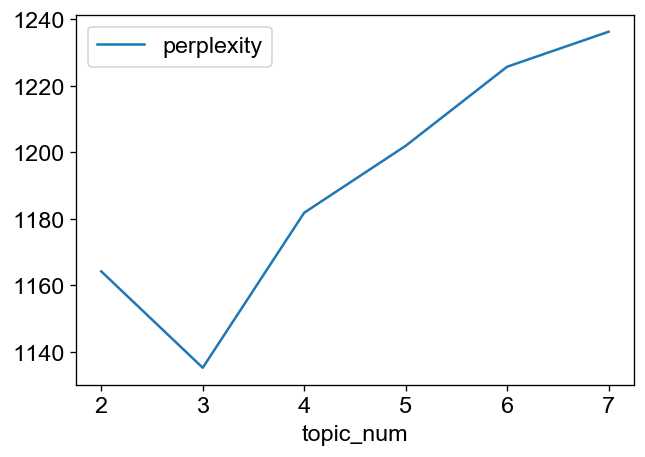

In [34]:
result.plot.line(x='topic_num', y='perplexity')

<Axes: xlabel='topic_num'>

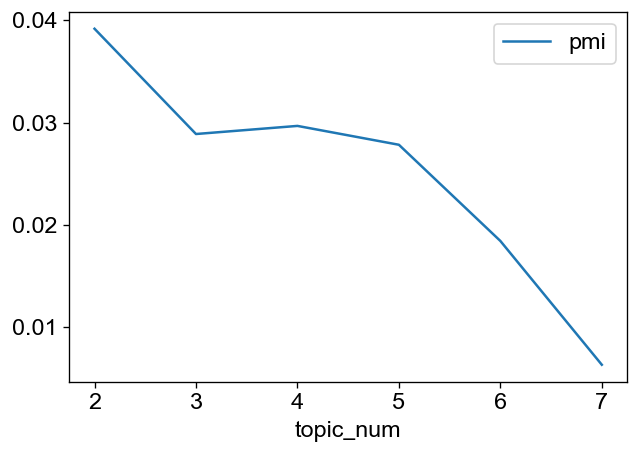

In [35]:
result.plot.line(x='topic_num', y='pmi')

從訓練結果來看，或發現perplexity在 3 最好，而pmi則是2或3較佳，故以下best_model建立將選擇3作為num_topics

In [36]:
#本小組依以上結果，選擇num_topics為3
best_model = LdaModel(
    corpus = corpus,
    num_topics = 3,
    id2word=dictionary,
    random_state = 1500,
    passes = 5 # 訓練次數
    )

2024-05-05 23:12:56,470 : INFO : using symmetric alpha at 0.3333333333333333
2024-05-05 23:12:56,473 : INFO : using symmetric eta at 0.3333333333333333
2024-05-05 23:12:56,477 : INFO : using serial LDA version on this node
2024-05-05 23:12:56,479 : INFO : running online (multi-pass) LDA training, 3 topics, 5 passes over the supplied corpus of 1249 documents, updating model once every 1249 documents, evaluating perplexity every 1249 documents, iterating 50x with a convergence threshold of 0.001000
2024-05-05 23:12:56,480 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2024-05-05 23:12:56,825 : INFO : -8.458 per-word bound, 351.6 perplexity estimate based on a held-out corpus of 1249 documents with 72807 words
2024-05-05 23:12:56,826 : INFO : PROGRESS: pass 0, at document #1249/1249
2024-05-05 23:12:57,084 : INFO : topic #0 (0.333): 0.010*"覺得" + 0.009*"比較" + 0.009*"教授" + 0.007*"真的" + 0.007*"知道" + 0.006*"

In [37]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(best_model, corpus, dictionary)
p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.149368 -0.026233       1        1  44.368546
0      0.150792 -0.025497       2        1  38.871897
1     -0.001424  0.051731       3        1  16.759557, topic_info=     Term        Freq       Total Category  logprob  loglift
19     喜歡  705.000000  705.000000  Default  30.0000  30.0000
2686   教授  341.000000  341.000000  Default  29.0000  29.0000
107    上衣  492.000000  492.000000  Default  28.0000  28.0000
22     外套  455.000000  455.000000  Default  27.0000  27.0000
44     搭配  514.000000  514.000000  Default  26.0000  26.0000
...   ...         ...         ...      ...      ...      ...
372    好看   41.601991  217.671860   Topic3  -5.6812   0.1314
352    發現   38.177433  147.711602   Topic3  -5.7671   0.4332
217    問題   41.975393  260.076819   Topic3  -5.6723  -0.0377
107    上衣   40.516425  492.039672   Topic3  -5.7077  -0.7107
238    最近   39.308442  314.909866   Topic3  -5.7379  -0.2946

[238 rows x 6 columns], token_table=      Topic      Freq Term
term                      
466       1  0.307608   一下
466       2  0.502677   一下
466       3  0.191317   一下
0         1  0.385935   一些
0         2  0.482419   一些
...     ...       ...  ...
677       2  0.014491   高領
677       3  0.028982   高領
193       1  0.944505   黑色
193       2  0.017173   黑色
193       3  0.040070   黑色

[528 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2])

In [42]:
#將主題改成5看看差異
model_5 = LdaModel(
    corpus = corpus,
    num_topics = 5,
    id2word=dictionary,
    random_state = 1500,
    passes = 5 # 訓練次數
    )

## LDAvis
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(model_5, corpus, dictionary)
p

2024-05-05 23:16:45,131 : INFO : using symmetric alpha at 0.2
2024-05-05 23:16:45,135 : INFO : using symmetric eta at 0.2
2024-05-05 23:16:45,138 : INFO : using serial LDA version on this node
2024-05-05 23:16:45,141 : INFO : running online (multi-pass) LDA training, 5 topics, 5 passes over the supplied corpus of 1249 documents, updating model once every 1249 documents, evaluating perplexity every 1249 documents, iterating 50x with a convergence threshold of 0.001000
2024-05-05 23:16:45,143 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2024-05-05 23:16:45,455 : INFO : -8.624 per-word bound, 394.4 perplexity estimate based on a held-out corpus of 1249 documents with 72807 words
2024-05-05 23:16:45,455 : INFO : PROGRESS: pass 0, at document #1249/1249
2024-05-05 23:16:45,682 : INFO : topic #0 (0.200): 0.012*"教授" + 0.011*"比較" + 0.009*"覺得" + 0.006*"真的" + 0.006*"朋友" + 0.006*"目前" + 0.006*"知道" + 0.006*"分享" 

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.160542  0.017156       1        1  32.436314
0      0.185067 -0.044149       2        1  31.818692
2     -0.081750 -0.066486       3        1  13.526568
1      0.058346  0.094075       4        1  13.254582
4     -0.001121 -0.000596       5        1   8.963844, topic_info=     Term        Freq       Total Category  logprob  loglift
2686   教授  358.000000  358.000000  Default  30.0000  30.0000
107    上衣  488.000000  488.000000  Default  29.0000  29.0000
44     搭配  513.000000  513.000000  Default  28.0000  28.0000
1600   面試  159.000000  159.000000  Default  27.0000  27.0000
22     外套  452.000000  452.000000  Default  26.0000  26.0000
...   ...         ...         ...      ...      ...      ...
203    之前   22.826612  148.458934   Topic5  -5.6557   0.5396
269    這次   23.978255  236.667637   Topic5  -5.6064   0.1225
64     真的   27.052782  663.070255   Topic5  -5.4858  -0.7871
2      一點   23.986214  247.805763   Topic5  -5.6061   0.0768
91     適合   23.241641  260.121910   Topic5  -5.6377  -0.0032

[389 rows x 6 columns], token_table=      Topic      Freq Term
term                      
466       1  0.159567   一下
466       2  0.398918   一下
466       3  0.132973   一下
466       4  0.178563   一下
466       5  0.129174   一下
...     ...       ...  ...
193       1  0.727078   黑色
193       2  0.011633   黑色
193       3  0.186132   黑色
193       4  0.023267   黑色
193       5  0.058166   黑色

[1107 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 3, 2, 5])

In [ ]:
#pyLDAvis.save_html(p, "lda_zh.html")

從上面兩張圖可看出若以Topic 3為例來做比較：

設定3個主題的 Top-30 Most Relevant Terms for Topic 3 為 16.8%， 設定5個主題的 Top-30 Most Relevant Terms for Topic 3 為 13.5%，

以此可知3個主題的Relevant Terms來得更好。


# 4.GuidedLDA

LDA作為當前主流的主題模型算法之一，可快速地概括大量對話的主要內容，
但是在某些主題關鍵詞的描述上並不是特別的準確，多個主題之間容易產生交叉以及容易出現話題無關的關鍵詞。

GuidedLDA 是可選半監督主題識別算法，所謂“可選”是指，可以提前設置主題的種子詞
再將後有選擇的把自定義的主題傳入模型中， 通過設置種子詞，引導算法朝預設的話題方向匯集，達到話題半監督的目的。




In [116]:
#安裝GuidedLDA
#pip install git+https://github.com/Text-Analytics-and-Retrieval/GuidedLDA.git#egg=GuidedLDA

  Cloning https://github.com/Text-Analytics-and-Retrieval/GuidedLDA.git to /private/var/folders/ng/25l3_vws2cl593j20n75bcy00000gn/T/pip-install-dluzvdey/guidedlda_54d6d21c8913453392fd58032417192c
  Running command git clone --filter=blob:none --quiet https://github.com/Text-Analytics-and-Retrieval/GuidedLDA.git /private/var/folders/ng/25l3_vws2cl593j20n75bcy00000gn/T/pip-install-dluzvdey/guidedlda_54d6d21c8913453392fd58032417192c
  Resolved https://github.com/Text-Analytics-and-Retrieval/GuidedLDA.git to commit 05c3bf2c18f9d126cc5170256f33e6c1fbc90052
  Preparing metadata (setup.py) ... done
  Created wheel for GuidedLDA: filename=guidedlda-2.0.0.dev31-cp39-cp39-macosx_11_0_arm64.whl size=2305258 sha256=6d6fb9bda7d0b1af211d48f8ae173f2cc1d005190544af279f0aea0abbf2b50b
  Stored in directory: /private/var/folders/ng/25l3_vws2cl593j20n75bcy00000gn/T/pip-ephem-wheel-cache-ejcmfpdn/wheels/a0/96/f9/fffcece983647506ae73b361b4c72452442916cc1f7a856c1d
Successfully built GuidedLDA
Note: you may n

In [43]:
import guidedlda
vocab = tuple(dictionary.token2id.keys())
vocab[:10]

('一些', '一起', '一點', '下去', '不到', '乾淨', '側邊', '全身', '凸顯', '出去玩')

In [44]:
word2id = dictionary.token2id

In [45]:
#自行設定種子字詞
seed_topic_list = [
    ["搭配", "風格", "衣服", "造型", "材質"],
    ["運勢", "水瓶", "吸引", "處女座", "曖昧"],
    ["利率", "股票", "信貸", "信用卡", "儲蓄"],
    ["教授", "錄取", "實驗室", "中山", "背景"]
]

In [46]:
seed_topics = {}
for t_id, st in enumerate(seed_topic_list):
    for word in st:
        seed_topics[word2id[word]] = t_id

In [47]:
# guidedlda 需要 DTM 格式作為 input，因此這邊利用 corpus2dense() 方法進行轉換
X = corpus2dense(corpus, len(dictionary), len(corpus)).T.astype(np.int64)

model = guidedlda.GuidedLDA(n_topics=5, n_iter=100, random_state=7, refresh=20)
model.fit(X, seed_topics=seed_topics, seed_confidence=1)

2024-05-05 23:18:01,329 : INFO : n_documents: 1249
2024-05-05 23:18:01,330 : INFO : vocab_size: 2785
2024-05-05 23:18:01,330 : INFO : n_words: 72807
2024-05-05 23:18:01,331 : INFO : n_topics: 5
2024-05-05 23:18:01,331 : INFO : n_iter: 100
2024-05-05 23:18:01,334 : WARNING : all zero row in document-term matrix found
2024-05-05 23:18:01,588 : INFO : <0> log likelihood: -709582
2024-05-05 23:18:01,663 : INFO : <20> log likelihood: -531754
2024-05-05 23:18:01,737 : INFO : <40> log likelihood: -526408
2024-05-05 23:18:01,810 : INFO : <60> log likelihood: -524574
2024-05-05 23:18:01,883 : INFO : <80> log likelihood: -523252
2024-05-05 23:18:01,956 : INFO : <99> log likelihood: -521773


In [48]:
# 整理／顯示主題模型結果
#n_top_words = 10
n_top_words = 5
topic_word = model.topic_word_

for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][: -(n_top_words + 1) : -1]
    #列出每個主題的常用字詞
    print("Topic {}: {}".format(i, " ".join(topic_words)))
    

doc_topic = model.doc_topic_
term_freq = tuple(dictionary.cfs.values())
doc_len = [sum(v for k, v in doc) for doc in corpus]

## LDAvis
pyLDAvis.enable_notebook()
p = pyLDAvis.prepare(topic_word, doc_topic, doc_len, vocab = vocab, term_frequency = term_freq)
p

Topic 0: 喜歡 搭配 上衣 外套 分享
Topic 1: 朋友 覺得 喜歡 真的 知道
Topic 2: 投資 目前 利率 股票 貸款
Topic 3: 教授 老師 請問 面試 比較
Topic 4: 分享 最後 看到 時間 需要


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.329815 -0.029092       1        1  38.412623
4     -0.075831  0.303325       2        1  20.216016
3     -0.135272  0.009728       3        1  14.479482
1      0.080443 -0.080972       4        1  13.543560
2     -0.199154 -0.202988       5        1  13.348320, topic_info=     Term        Freq       Total Category  logprob  loglift
2686   教授  354.000000  354.000000  Default  30.0000  30.0000
2044   投資  243.000000  243.000000  Default  29.0000  29.0000
107    上衣  494.000000  494.000000  Default  28.0000  28.0000
19     喜歡  728.000000  728.000000  Default  27.0000  27.0000
44     搭配  518.000000  518.000000  Default  26.0000  26.0000
...   ...         ...         ...      ...      ...      ...
50     比較   75.804556  597.914605   Topic5  -4.8536  -0.0515
358    請問   56.855911  260.327409   Topic5  -5.1413   0.4924
238    最近   48.877533  322.479447   Topic5  -5.2925   0.1271
115    建議   46.882939  173.641425   Topic5  -5.3341   0.7044
614    每個   44.888345   92.830741   Topic5  -5.3776   1.2872

[307 rows x 6 columns], token_table=      Topic      Freq Term
term                      
466       1  0.263124   一下
466       2  0.115342   一下
466       3  0.331608   一下
466       4  0.209057   一下
466       5  0.082902   一下
...     ...       ...  ...
142       2  0.016409   風格
142       3  0.060167   風格
2167      4  0.062603   風險
2167      5  0.939041   風險
193       1  1.000813   黑色

[472 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 4, 2, 3])

以下為將主題的字詞及字詞出現次數，存成不同的csv檔

In [51]:
dcard_df.loc[dcard_df['artCatagory']=='穿搭', "words"].to_csv("./2024_study_group9_3/words.csv")
dcard_df.loc[dcard_df['artCatagory']=='理財', "words"].to_csv("./2024_study_group9_3/words_fin.csv")

In [52]:
dcard_df.loc[dcard_df['artCatagory']=='穿搭', "words"].explode().value_counts().to_csv("./2024_study_group9_3/words_count.csv")
dcard_df.loc[dcard_df['artCatagory']=='理財', "words"].explode().value_counts().to_csv("./2024_study_group9_3/words_count_fin.csv")

# 5.主題分佈的應用，搭配其他文章資訊

In [54]:
# 取得每條PO文的主題分佈，以model_5模型來找出主題
topics_doc = model_5.get_document_topics(corpus)

In [55]:
topics_doc[100]

[(0, 0.023165436),
 (1, 0.022770187),
 (2, 0.9086551),
 (3, 0.022617752),
 (4, 0.02279154)]

In [56]:
m_theta = corpus2csc(topics_doc).T.toarray()
m_theta

array([[0.        , 0.        , 0.        , 0.99457639, 0.        ],
       [0.        , 0.        , 0.771106  , 0.21935941, 0.        ],
       [0.        , 0.        , 0.64554709, 0.34908393, 0.        ],
       ...,
       [0.91743213, 0.07102628, 0.        , 0.        , 0.        ],
       [0.07912164, 0.91750115, 0.        , 0.        , 0.        ],
       [0.95187998, 0.01207378, 0.01203546, 0.01196264, 0.01204818]])

In [57]:
#讓topic_label從 0~4 改成1~5
dcard_df['topic_label'] = m_theta.argmax(axis=1) + 1
dcard_df['topic_label']

0       4
1       3
4       3
6       4
7       3
       ..
3588    1
3590    1
3591    1
3592    2
3594    1
Name: topic_label, Length: 1249, dtype: int64

In [58]:
#列出topic_label值的次數
dcard_df['topic_label'].value_counts()

topic_label
1    605
4    233
2    150
5    134
3    127
Name: count, dtype: int64

In [59]:
dcard_df.head()

,content,artUrl,artCatagory,artDate,words,topic_label
0,大家好我是身高體重很喜歡裙裝所以衣櫃裡幾乎找不到褲子照片都是出去玩時拍的不過是出遊順便拍的不...,https://www.dcard.tw/f/dressup/p/255078442,穿搭,2024-03-25 16:18:42,"[身高體重, 喜歡, 裙裝, 衣櫃, 不到, 褲子, 照片, 出去玩, 出遊, 順便, 專業...",4
1,麵包超人因為本身長相無優勢所以決定用麵包超人的型態出場窮超人本人真的好想獲得購物金第一套是休...,https://www.dcard.tw/f/dressup/p/255078768,穿搭,2024-03-25 16:54:35,"[超人, 長相, 優勢, 決定, 超人, 型態, 出場, 超人, 真的, 獲得, 購物, 第...",3
4,哈囉大家好久不見竟然隔了兩年風格跟以前好像轉變蠻大的現在都穿深色系為主簡單又搭啊身高體重還是...,https://www.dcard.tw/f/dressup/p/255065394,穿搭,2024-03-24 10:59:45,"[哈囉, 好久不見, 兩年, 風格, 以前, 好像, 轉變, 蠻大, 現在, 深色, 系為,...",3
6,嗨嗨我是寧這次想來和大家分享我最近新入手的日牌洋裝們果然小隻女孩買日牌就是不會錯長度都會很剛...,https://www.dcard.tw/f/dressup/p/255047494,穿搭,2024-03-22 10:00:10,"[是寧, 這次, 想來, 分享, 最近, 入手, 日牌, 洋裝, 女孩, 買日牌, 不會錯,...",4
7,哈囉大家好我是草莓奶昔平常都在美妝版出沒的我今天要來分享套可甜可鹹的穿搭有興趣的就一起看下去...,https://www.dcard.tw/f/dressup/p/255065466,穿搭,2024-03-24 11:08:57,"[哈囉, 草莓, 奶昔, 平常, 美妝版, 出沒, 今天, 要來, 分享, 興趣, 一起, ...",3


In [60]:
#將artDate進行時間格式轉換
dcard_df['artDate'] = pd.to_datetime(dcard_df['artDate'])
dcard_df['artDate']

0      2024-03-25 16:18:42
1      2024-03-25 16:54:35
4      2024-03-24 10:59:45
6      2024-03-22 10:00:10
7      2024-03-24 11:08:57
               ...        
3588   2024-03-01 12:00:12
3590   2024-03-03 11:16:03
3591   2024-03-01 11:01:16
3592   2024-03-03 13:10:51
3594   2024-03-03 22:40:19
Name: artDate, Length: 1249, dtype: datetime64[ns]

In [61]:
dcard_df['artDate'].dt.date

0       2024-03-25
1       2024-03-25
4       2024-03-24
6       2024-03-22
7       2024-03-24
           ...    
3588    2024-03-01
3590    2024-03-03
3591    2024-03-01
3592    2024-03-03
3594    2024-03-03
Name: artDate, Length: 1249, dtype: object

In [62]:
#透過groupby合併日期，列出資料集中2024-03-01 到 2024-03-25 每日不同主題的比率
dcard_df.groupby(dcard_df['artDate'].dt.date)['topic_label'].value_counts(normalize=True)

artDate     topic_label
2024-03-01  1              0.724409
            4              0.118110
            5              0.062992
            2              0.055118
            3              0.039370
                             ...   
2024-03-25  4              0.550000
            3              0.300000
            1              0.050000
            2              0.050000
            5              0.050000
Name: proportion, Length: 113, dtype: float64

In [63]:
date_topic = dcard_df.groupby(dcard_df['artDate'].dt.date)['topic_label'].value_counts(normalize=True).unstack()
date_topic.head()

topic_label,1,2,3,4,5
artDate,,,,,
2024-03-01,0.724409,0.055118,0.039370,0.118110,0.062992
2024-03-02,0.647887,0.126761,0.014085,0.084507,0.126761
2024-03-03,0.621951,0.109756,0.109756,0.048780,0.109756
2024-03-04,0.588889,0.100000,0.055556,0.144444,0.111111
2024-03-05,0.642857,0.157143,0.057143,0.114286,0.028571


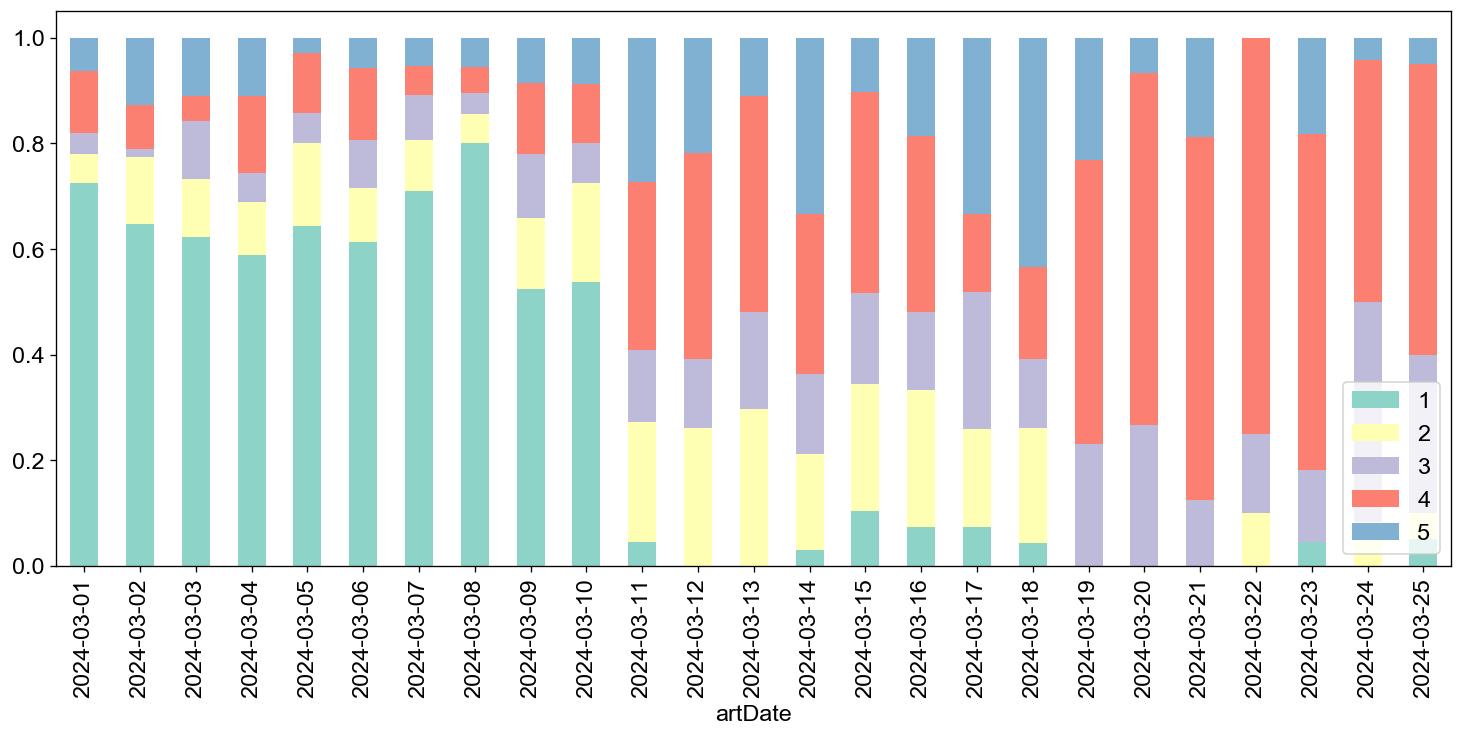

In [64]:
#搭配文章中的日期資訊資訊來結合主題分佈結果進行繪圖
fig, ax = plt.subplots(figsize=(15, 6))
date_topic.plot.bar(ax=ax, stacked=True, color = plt.cm.Set3.colors)
ax.legend(loc='lower right')

此圖結果為透過主題模型與日期的結合運用案例，從上面model_5模型的圖形就可看出topic1是穿搭版，

主題1 在 3/1-3/10 被討論的比例很高，很大原因可能是當時正值開學時期，事情較少且有很多活動，

像是社團或系上可能都有，因此出門穿搭就顯得極為重要，因此在此時期廣受學生討論。

可以透過搭配文章的資訊（例如日期等），讓主題模型的結果能做出更多的分析應用，以此來做為後續研究探索的目標。